In [1]:
import pandas as pd
import numpy as np
import os.path as op

source_folder = '/Users/mrenke/data/ds-dnumrisk/derivatives/phenotype'

df_participants = pd.read_csv(op.join('/Users/mrenke/data/ds-dnumrisk/add_tables','subjects_recruit&scan_scanned-final.csv'), header=0) #, index_col=0
df_participants = df_participants.loc[:,['subject ID', 'age','group','gender']].rename(mapper={'subject ID': 'subject'},axis=1).dropna().astype({'subject': int, 'group': int}).set_index('subject')


In [2]:
rnps = pd.read_csv(op.join(source_folder, 'rnp_sub-format-wise.csv'))
df_rnp = rnps.set_index(['subject', 'format']).unstack('format')
df_rnp = df_rnp.droplevel(0, axis=1, ).rename(columns={'non-symbolic': 'rnp_nonsymb','symbolic': 'rnp_symb'})


In [2]:
math_stuff = pd.read_csv(op.join(source_folder, 'math_skill&confidence&anxiety-means.csv')).set_index('subject')
decode = pd.read_csv(op.join(source_folder, 'decoding_r.csv')).set_index('subject')

In [3]:
gammas_symbolic = pd.read_csv(op.join(source_folder, f'probit_model-2_format-symbolic_gammas.csv'))
gammas_symbolic = gammas_symbolic.set_index('subject').drop(columns=['Unnamed: 0'])
gammas_nonsymbolic = pd.read_csv(op.join(source_folder, f'probit_model-2_format-non-symbolic_gammas.csv'))
gammas_nonsymbolic = gammas_nonsymbolic.set_index('subject').drop(columns=['Unnamed: 0'])
gammas = gammas_symbolic.join(gammas_nonsymbolic, lsuffix='_symbolic', rsuffix='_nonsymbolic')
gammas['gamma_mean'] = gammas.mean(axis=1)
gammas.head()

,gamma_symbolic,gamma_nonsymbolic,gamma_mean
subject,,,
14,2.015729,1.469922,1.742826
24,5.097580,2.534791,3.816185
15,1.635386,2.301141,1.968264
12,2.637042,1.980849,2.308945
52,2.395022,2.463237,2.429129


In [6]:
panamath_scores = pd.read_csv('/Users/mrenke/data/ds-dnumrisk/add_tables/panamath_AllRunsSummary.csv')
panamath_scores.columns


Index(['Subject ID', 'Test End Date Time', 'Results File Name',
       'Number of Trials', 'Number of Correct Trials', 'Weber Fraction',
       'Percent Correct', 'Average RT', 'Variance RT', 'Average Correct RT',
       'Variance Correct RT', 'Number of Non-RT-Outlier Trials',
       'Number of Correct Non-RT-Outlier Trials',
       'Non-RT-Outlier Weber Fraction', 'Non-RT-Outlier Percent Correct',
       'Average Non-RT-Outlier RT', 'Variance Non-RT-Outlier RT',
       'Average Correct Non-RT-Outlier RT',
       'Variance Correct Non-RT-Outlier RT',
       'Number of Non-RT-Outlier Correct Trials',
       'Average Non-RT-Outlier Correct RT',
       'Variance Non-RT-Outlier Correct RT', 'Unnamed: 22'],
      dtype='object')

In [7]:
df_pana = panamath_scores.rename(mapper={'Subject ID': 'subject'}, axis=1).set_index('subject')[['Number of Trials','Weber Fraction', 'Percent Correct', 'Number of Non-RT-Outlier Trials']]
df_pana.rename(mapper={'Weber Fraction': 'weber_frac'}, inplace=True, axis=1)
df_pana.drop(999, axis=0, inplace=True)
df_pana.sort_index(inplace=True)
df_pana.head() # len(df_pana)   = 64
 

,Number of Trials,weber_frac,Percent Correct,Number of Non-RT-Outlier Trials
subject,,,,
1,264,0.143232,85.984848,263
2,264,0.119873,88.257576,259
3,264,0.349204,72.348485,257
4,264,0.183717,82.196970,257
5,264,0.154192,84.469697,255


In [5]:
df_comb = df_rnp.join(math_stuff).join(decode).join(df_pana['weber_frac']).join(gammas).join(df_participants)
df_comb['rnp_symb_dif'] = np.abs(df_comb['rnp_symb'] - 0.55)
df_comb['rnp_nonsymb_dif'] = np.abs(df_comb['rnp_nonsymb'] - 0.55)

df_comb.head()

NameError: name 'df_pana' is not defined

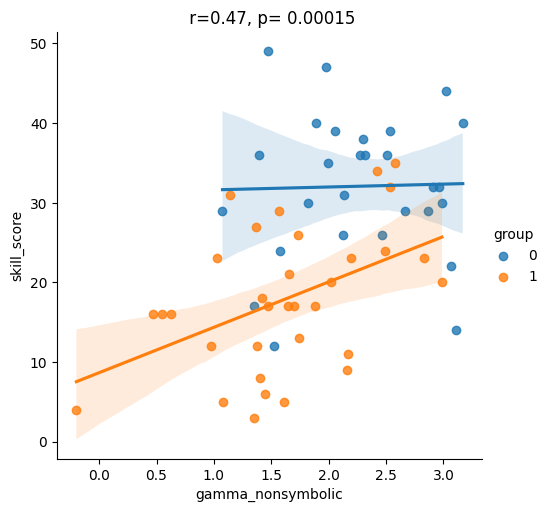

In [27]:
import seaborn as sns
import pingouin

y_var = 'skill_score' # '4c' # 4b' #
x_var = 'gamma_nonsymbolic' # 'conf_mean'
cor = pingouin.corr(df_comb[y_var], df_comb[x_var])
r_ = np.round(cor['r'][0], 2)
p = np.round(cor['p-val'][0], 5)

fig = sns.lmplot(x=x_var, y=y_var, data=df_comb, hue='group') #, hue='group'
fig.set(title=f' r={r_}, p= {p}')   #ylabel='Anxiety', xlabel='Skill', 

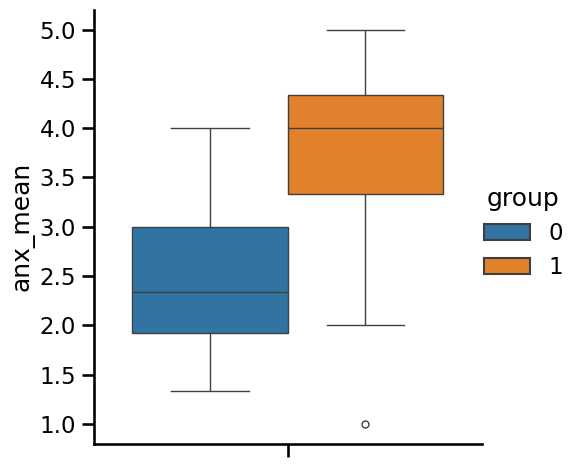

In [32]:
sns.set_context('talk')
sns.catplot(df_comb, y='anx_mean', hue='group',kind='box')

# test slope difference

In [4]:
df_comb = math_stuff.join(gammas).join(df_participants)
print(df_comb.index.unique())

df_comb.head()

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


,skill_score,anx_mean,conf_mean,gamma_symbolic,gamma_nonsymbolic,gamma_mean,age,group,gender
subject,,,,,,,,,
1,36.0,1.333333,2.666667,4.144728,2.316990,3.230859,19.0,0,w
2,6.0,2.666667,0.666667,0.804526,1.447929,1.126228,17.0,1,w
3,29.0,1.666667,3.333333,1.013945,1.074758,1.044351,15.0,0,w
4,34.0,4.000000,1.833333,1.937536,2.418975,2.178255,17.0,1,w
5,30.0,2.000000,2.333333,2.407660,1.819713,2.113687,20.0,0,w


In [15]:
import bambi

ind_var = 'gamma_symbolic'
formula = f'skill_score ~ {ind_var}*group' # + age + gender'

model = bambi.Model(formula, data=df_comb.reset_index())
results = model.fit(draws=5000, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [Intercept, gamma_symbolic, group, gamma_symbolic:group, skill_score_sigma]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 13 seconds.


0.8736


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,33.358,4.617,24.601,41.837,0.067,0.047,4730.0,6323.0,1.0
gamma_symbolic,-0.030,1.584,-3.103,2.878,0.023,0.016,4626.0,5748.0,1.0
group,-20.862,6.111,-31.852,-8.807,0.099,0.070,3847.0,4606.0,1.0
gamma_symbolic:group,2.850,2.497,-1.828,7.579,0.040,0.028,3900.0,5248.0,1.0
skill_score_sigma,9.340,0.843,7.767,10.899,0.011,0.008,6242.0,6448.0,1.0


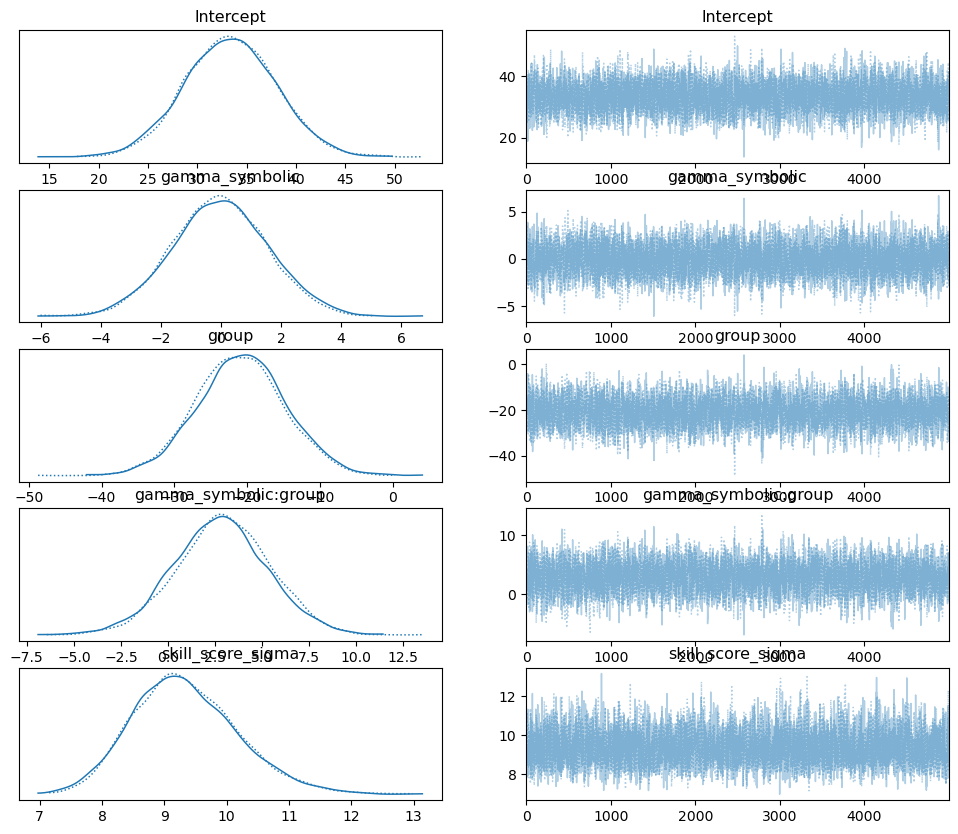

In [16]:
import arviz as az

p_val_int  = np.mean(results.posterior[f'{ind_var}:group'].to_dataframe().values > 0)
print(p_val_int)
az.plot_trace(results)
az.summary(results)

0.907